<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-инструментов-и-данных" data-toc-modified-id="Импорт-инструментов-и-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт инструментов и данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Разбивка-на-тренд-и-сезонные-составляющие" data-toc-modified-id="Разбивка-на-тренд-и-сезонные-составляющие-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбивка на тренд и сезонные составляющие</a></span></li><li><span><a href="#Параметры-после-анализа" data-toc-modified-id="Параметры-после-анализа-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Параметры после анализа</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная" data-toc-modified-id="Линейная-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#Сравнение" data-toc-modified-id="Сравнение-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Сравнение</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Визуализация" data-toc-modified-id="Визуализация-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Визуализация</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорт инструментов и данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm.sklearn import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit


In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


### Предобработка

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [5]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


###

## Анализ

### Разбивка на тренд и сезонные составляющие

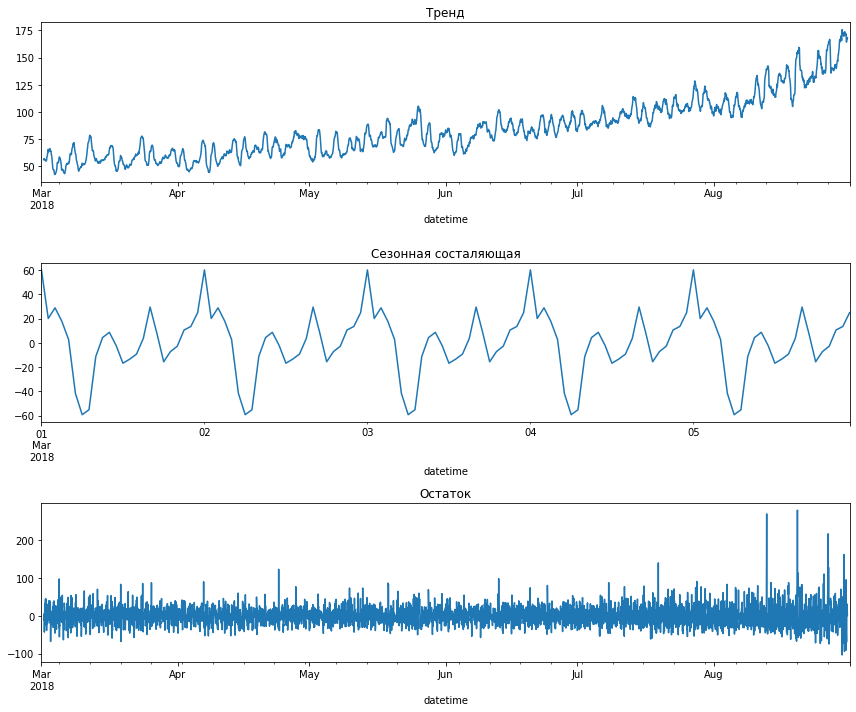

In [6]:
decomposed = seasonal_decompose(data)
 
plt.figure(figsize=(12, 10)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Сезонная состаляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

<b>Вывод:</b>

Прогноз делается на сутки => скользящее среднее 24 часа  
Лаги подберем перебором по часам  

Использовать кросс-валидацию будем с параметором TimeSeriesSplit.   
Результаты расчета функции сохранятся в отдельный список data_temp. 

Исходя из графиков определеям календарные признаки будем закладывать в модель:

Месяц и число (по графику тренда) так как прослеживается рост по месяцам и дням, притом довольно пропорциональный
Часы (по графику сезонности) так как прослеживается цикличное изменение по часам 
 

In [7]:
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

In [8]:
def make_features(data, max_lag, rolling_mean_size):
  

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    X_train = train.drop('num_orders',axis=1)
    X_test = test.drop('num_orders',axis=1)
    Y_train = train['num_orders']
    Y_test = test['num_orders']

    model = LinearRegression()
    rsme = -cross_val_score(model, X_train, Y_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
    print(f'RSME = {rsme.round(2)} при lag= {max_lag}')
    return data

In [9]:
display(make_features(data, 1, 24).head(3))
display(make_features(data, 3, 24).head(3))
display(make_features(data, 6, 24).head(3))
display(make_features(data, 12, 24).head(3))
display(make_features(data, 24, 24).head(3))

RSME = 31.54 при lag= 1


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN


RSME = 31.46 при lag= 3


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN


RSME = 31.48 при lag= 6


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,NaN


RSME = 31.36 при lag= 12


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RSME = 26.94 при lag= 24


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Параметры после анализа

Минимальное значение RSME при lag= 24  
Далее придерживаемся данных условий  

In [10]:
make_features(data, 24, 24)
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()
    
X_train = train.drop('num_orders',axis=1)
X_test = test.drop('num_orders',axis=1)
Y_train = train['num_orders']
Y_test = test['num_orders']


RSME = 26.94 при lag= 24


In [11]:
display(X_train.shape)
display(Y_train.shape)
display(X_test.shape)
display(Y_test.shape)

(3950, 29)

(3950,)

(442, 29)

(442,)

## Обучение

###  Линейная

In [12]:
model_lr = LinearRegression() 
model_lr.fit(X_train, Y_train)
 
predictions = model_lr.predict(X_test)  
print("RMSE:",mean_squared_error(Y_test,predictions,squared= False))

RMSE: 45.81094888906951


### Дерево решений

In [13]:
model_DT= DecisionTreeRegressor(random_state=12345)
param_grid = {  'min_samples_split': range(2, 20),  "max_depth" : range(15,16),"min_samples_leaf" : range(20,30)}

gsearch = GridSearchCV(model_DT, 
                       param_grid = param_grid, 
                       scoring='neg_root_mean_squared_error', 
                       cv=TimeSeriesSplit(n_splits=5))

model_DT = gsearch.fit(X_train,Y_train)
print(f'Лучшая RMSE: {-model_DT.best_score_} при параметрах {model_DT.best_params_}')

Лучшая RMSE: 28.776013240838164 при параметрах {'max_depth': 15, 'min_samples_leaf': 27, 'min_samples_split': 2}


### LGBM

In [14]:
LGBM_model= LGBMRegressor(random_state=12345, n_jobs=2)

param_grid = { "max_depth" : range(10,20), "n_estimators" : range(50,60)}

gsearch = GridSearchCV(LGBM_model, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
LGBM_model = gsearch.fit(X_train,Y_train)
print(f'Best RMSE: {-LGBM_model.best_score_} при параметрах ,{LGBM_model.best_params_}')

Best RMSE: 24.853726148098758 при параметрах ,{'max_depth': 11, 'n_estimators': 52}


Минимальное значение RSME= 24.853726148098758 при обучении модели методом LGBM. 
Гиперпараметры {'max_depth': 11, 'n_estimators': 52}

### Сравнение

In [15]:
RSME_lr = -cross_val_score(model_lr, 
                           X_train, 
                           Y_train, 
                           scoring='neg_root_mean_squared_error', 
                           cv=TimeSeriesSplit(n_splits=5)).mean()

RSME_DT = -cross_val_score(model_DT, 
                           X_train, 
                           Y_train, 
                           scoring='neg_root_mean_squared_error', 
                           cv=TimeSeriesSplit(n_splits=5)).mean()
RSME_LGBM= -cross_val_score(LGBM_model, 
                             X_train, 
                             Y_train,  
                             scoring='neg_root_mean_squared_error', 
                             cv=TimeSeriesSplit(n_splits=5)).mean()
print( RSME_lr , RSME_DT ,RSME_LGBM)

26.941338395918326 28.963286602403134 24.967172120164644


## Тестирование

Финальные тесты

In [16]:
 
lr_predictions = model_lr.predict(X_test)
RSME_lr_test = mean_squared_error(Y_test, lr_predictions,squared= False)

In [17]:
 
DT_predictions = model_DT.predict(X_test)
RSME_DT_test = mean_squared_error(Y_test, DT_predictions,squared= False)

In [18]:
  
LGBM_predictions = LGBM_model.predict(X_test)
RSME_LGBM_test = mean_squared_error(Y_test, LGBM_predictions,squared= False)

In [19]:

print(RSME_lr_test,RSME_DT_test,RSME_LGBM_test )

45.81094888906951 56.188282345206964 41.815066813207096


### Визуализация

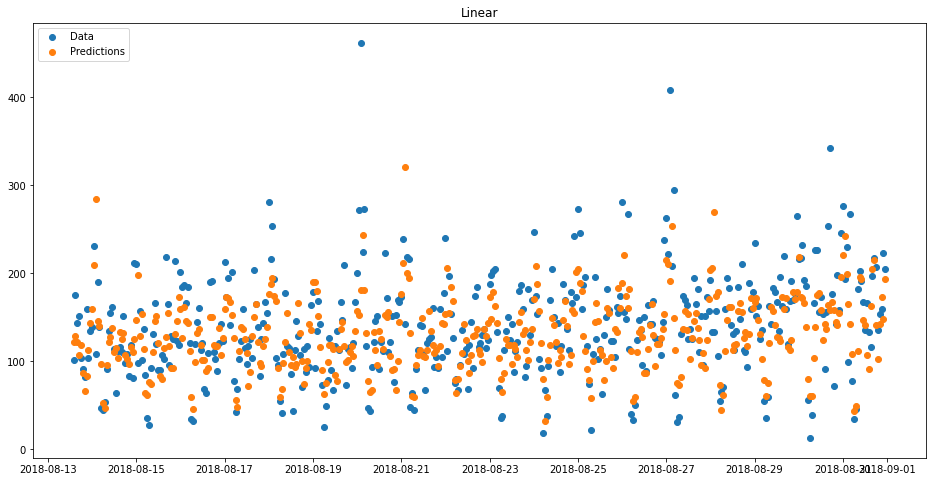

In [23]:
plt.figure(figsize=(16, 8)) 
plt.scatter(y= Y_test, x= Y_test.index, label='Data')
plt.scatter(y= lr_predictions, x= Y_test.index, label='Predictions')
plt.legend(loc='upper left')
plt.title('Linear')
plt.show() 
 


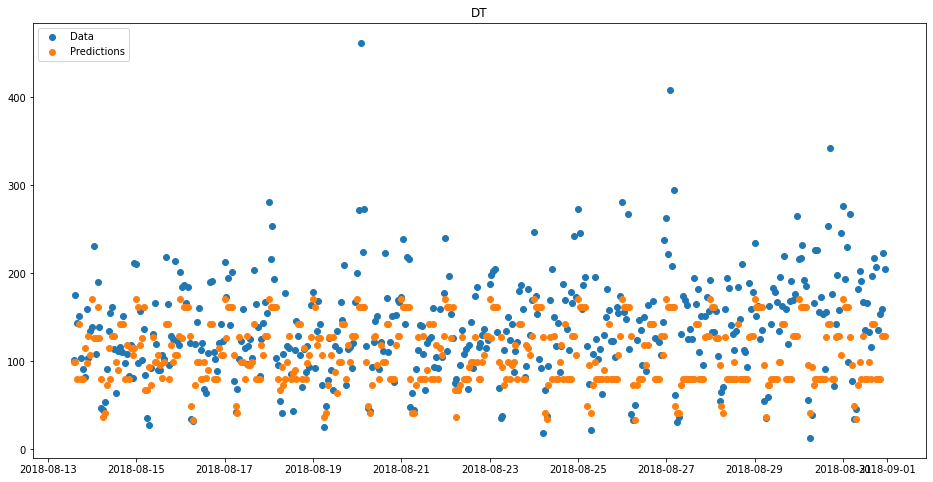

In [24]:
plt.figure(figsize=(16, 8)) 
plt.scatter(y= Y_test, x= Y_test.index, label='Data')
plt.scatter(y= DT_predictions, x= Y_test.index, label='Predictions')
plt.legend(loc='upper left')
plt.title('DT')
plt.show() 
 

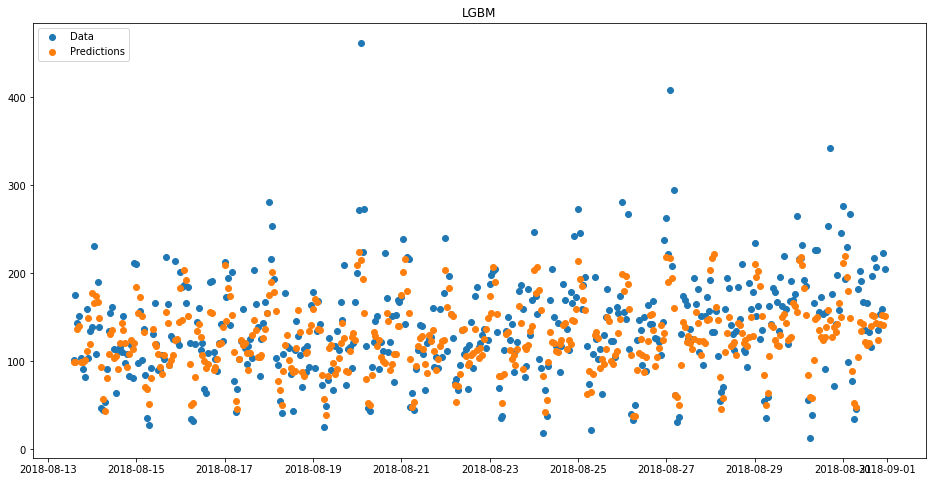

In [25]:
plt.figure(figsize=(16, 8)) 
plt.scatter(y= Y_test, x= Y_test.index, label='Data')
plt.scatter(y= LGBM_predictions, x= Y_test.index, label='Predictions')
plt.legend(loc='upper left')
plt.title('LGBM')
plt.show() 
 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

## Вывод  





В ходе проекта были обработаны данные о заказах такси. 
 
Для прогноза количества заказов такси были построены 3 модели предскания.  

Самой эффективной моделью, которая показала минимальную метрику RSME(41.815 ) является модель градиентного бустинга библиотеки LightGBM. 

Требование о значении метрики RMSE выполнено.